In [112]:
import matplotlib.pyplot as plt
import pandas as pd
import os

from src.settings import RAW_PATH

In [2]:
raw_files = os.listdir(RAW_PATH)
raw_files

['sales_train.csv',
 'shops.csv',
 'test.csv',
 'item_categories.csv',
 'items.csv',
 'sample_submission.csv']

Clearly, not all of the files provided are useful for training. In particular, "test", "sample_submission" are admin, so will remove from the dict.

In [13]:
for item in ['test.csv', 'sample_submission.csv']:
    try:
        raw_files.remove(item)
    except ValueError:
        print(f'{item} not found in list')

test.csv not found in list
sample_submission.csv not found in list


For convinience let's add all raw files to one dict

In [73]:
raw_files_di = {}
for f in raw_files:
    path = RAW_PATH + f
    raw_files_di[f.split('.')[0]] = pd.read_csv(path)
    

In [43]:
# reading files and looking at headers
for el in raw_files_di:
    print(el,':\n', raw_files_di[el].head())
    print('='*30, '\n\n')

sales_train :
          date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0


shops :
                         shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4


item_categories :
         item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP

All the columns are more or less obsious except for `date_block_num` in the `sales_train` file, let's look at it separately.

Text(0, 0.5, 'observation counts')

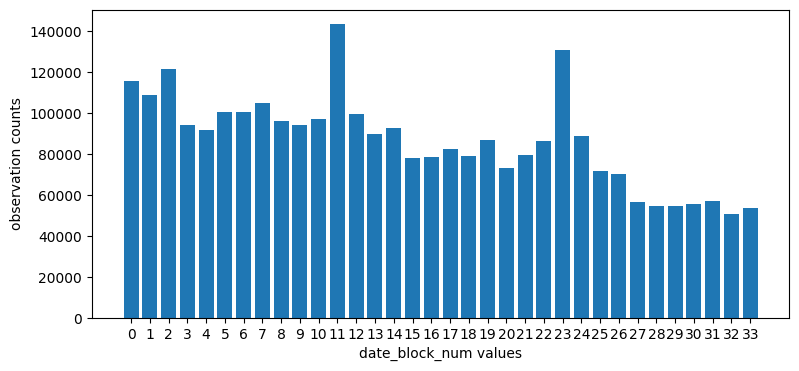

In [121]:
#looking at histogram
cntr = raw_files_di['sales_train']['date_block_num'].value_counts().sort_index()

plt.figure(figsize=[9,4])
plt.bar(cntr.index, cntr.values)
plt.xticks(ticks=cntr.index, labels=cntr.index);
plt.xlabel('date_block_num values'); plt.ylabel('observation counts')

Interesting, so there are more that 12 values, so grouping is not my month only. Also, interestingly there are less observations with greater values of this feature, a clear trend.

Let's check if the mapping is to month/year values.

In [75]:
# iterating through values
for val in raw_files_di['sales_train']['date_block_num'].unique()[:4]:
    print(raw_files_di['sales_train'][raw_files_di['sales_train']['date_block_num'] == val].head())
    print('='*30)

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
115690  21.02.2013               1       50     3880      1499.0           1.0
115691  14.02.2013               1       50     3880      1499.0           1.0
115692  21.02.2013               1       50     4128       899.0           1.0
115693  13.02.2013               1       50     4124       249.0           1.0
115694  24.02.2013               1       50     3880      1499.0           1.0
              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
224

Ok, so seems like each `data_block_num` value corresponds to only 1 month value. Let's reconfirm.

In [76]:
# casting to proper datetime type
raw_files_di['sales_train']['date'] = pd.to_datetime(raw_files_di['sales_train']['date'], format="%d.%m.%Y")

In [85]:
# 33 unique values, more than there are months, so probably the mapping is to month/year
raw_files_di['sales_train']['date_block_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [91]:
for val in raw_files_di['sales_train']['date_block_num'].unique():
    cond = raw_files_di['sales_train']['date_block_num'] == val
    yr = raw_files_di['sales_train'][cond]['date'].dt.year.unique()[0]
    mnth = raw_files_di['sales_train'][cond]['date'].dt.month.unique()[0]
    print(f"{val}: {[yr, mnth]}")

0: [2013, 1]
1: [2013, 2]
2: [2013, 3]
3: [2013, 4]
4: [2013, 5]
5: [2013, 6]
6: [2013, 7]
7: [2013, 8]
8: [2013, 9]
9: [2013, 10]
10: [2013, 11]
11: [2013, 12]
12: [2014, 1]
13: [2014, 2]
14: [2014, 3]
15: [2014, 4]
16: [2014, 5]
17: [2014, 6]
18: [2014, 7]
19: [2014, 8]
20: [2014, 9]
21: [2014, 10]
22: [2014, 11]
23: [2014, 12]
24: [2015, 1]
25: [2015, 2]
26: [2015, 3]
27: [2015, 4]
28: [2015, 5]
29: [2015, 6]
30: [2015, 7]
31: [2015, 8]
32: [2015, 9]
33: [2015, 10]


Indeed we see that the `date_block_num` feature represents grouping of observations by combinations of month and year.

Some observations on data structure:

- `shops` -- a mapping of shops names to an ordinal categorical feature `shop_id`
- `item_categories` -- list of items' categories
- `items` -- unique list of items in stock, already merged with `item_categories` table
- `sales_train` -- main table for training with IDs of shops, items and sales date. Additional columns are `price` and `date_block_num`. 
    - `date_block_num` -- grouping of items by date, i.e. each value marks observations recorded within 1 month of the same year only. 
    - `price` -- price of item.

It makes sense to add the items grouping to the `sales_train` table by joining the `items` table and explore the data in the merged table afterwards. Let's do that.
